In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

from keras import regularizers
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Concatenate, BatchNormalization, Average, Convolution2D, MaxPooling2D, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras import initializers

from sklearn.metrics import classification_report

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

/home/bocharick/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bocharick/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bocharick/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bocharick/anaconda3/lib/python3.7/site-packages/tensorflow/python/f

1.14.0


In [2]:
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [3]:
cifar10 = keras.datasets.cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

train_labels = keras.utils.to_categorical(train_labels, len(class_names))
test_labels = keras.utils.to_categorical(test_labels, len(class_names))

In [4]:
train_images.shape

(50000, 32, 32, 3)

In [5]:
train_labels.shape

(50000, 10)

In [6]:
train_images = train_images.astype("float32") / 255.0

test_images = test_images.astype("float32") / 255.0

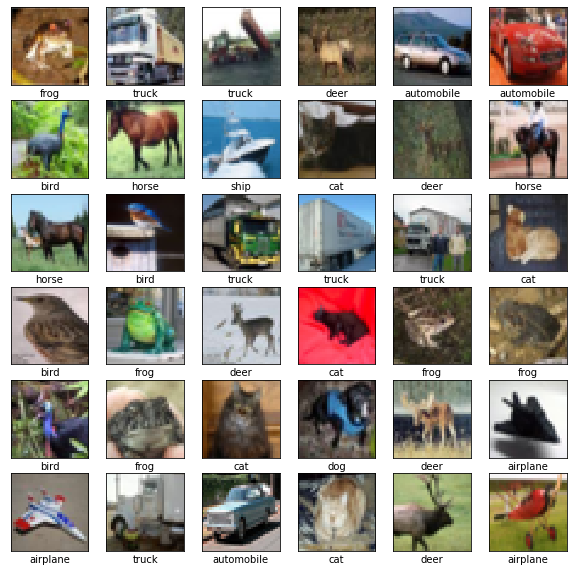

In [7]:
plt.figure(figsize=(10,10))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i].reshape(32,32,3), cmap=plt.cm.binary)
    plt.xlabel(class_names[np.argmax(train_labels[i])])
plt.show()

In [8]:
if tf.__version__.startswith("1."):
    val_acc_name = "val_acc"
    acc_name = "acc"
else:
    val_acc_name = "val_accuracy"
    acc_name = "accuracy"

## Baseline model

In [9]:
tf.keras.backend.clear_session()

DROPOUT_RATE = 0.2
DENSE_SIZE = 512

inputs = Input(shape=(32,32,3), name="Input")
h_0 = Flatten()(inputs)

h_1 = Dense(DENSE_SIZE, activation='relu', name="hidden_1")(h_0)
drop_1 = Dropout(DROPOUT_RATE, name="dropout_1")(h_1)

h_2 = Dense(DENSE_SIZE, activation='relu', name="hidden_2")(drop_1)
drop_2 = Dropout(DROPOUT_RATE, name="dropout_2")(h_2)

predictions = Dense(10, activation='softmax', name="Output")(drop_2)

model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
hidden_1 (Dense)             (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_2 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________

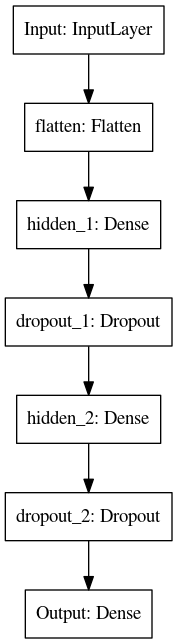

In [10]:
plot_model(model)

In [11]:
checkpoint = ModelCheckpoint('cifar10_base.hdf5',
                            monitor=val_acc_name,
                            save_best_only=True,
                            period=5,
                            verbose=1)
early_stopping_callback = EarlyStopping(monitor=val_acc_name, 
                                        min_delta=1e-9, 
                                        patience=50, 
                                        verbose=1, 
                                        mode='auto', 
                                        baseline=None, 
                                        restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor=val_acc_name,
                                           patience=5,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.00000001)

In [12]:
%%time
BATCH_SIZE = 1024
EPOCHS = 10000000000
history = model.fit(x=train_images, y=train_labels, batch_size=BATCH_SIZE,
                   epochs = EPOCHS,
                   validation_data=(test_images, test_labels),
                   
                   verbose=1,
                   callbacks=[checkpoint, learning_rate_reduction, early_stopping_callback])

Train on 50000 samples, validate on 10000 samples
Epoch 1/10000000000
50000/50000 [==============================] - 1s 15us/sample - loss: 2.2503 - acc: 0.2084 - val_loss: 1.9181 - val_acc: 0.3158
Epoch 2/10000000000
50000/50000 [==============================] - 1s 11us/sample - loss: 1.8753 - acc: 0.3241 - val_loss: 1.7858 - val_acc: 0.3683
Epoch 3/10000000000
50000/50000 [==============================] - 1s 11us/sample - loss: 1.7925 - acc: 0.3568 - val_loss: 1.6950 - val_acc: 0.3995
Epoch 4/10000000000
50000/50000 [==============================] - 1s 11us/sample - loss: 1.7434 - acc: 0.3760 - val_loss: 1.6508 - val_acc: 0.4128
Epoch 5/10000000000
49152/50000 [============================>.] - ETA: 0s - loss: 1.6997 - acc: 0.3926
Epoch 00005: val_acc improved from -inf to 0.43480, saving model to cifar10_base.hdf5
50000/50000 [==============================] - 1s 12us/sample - loss: 1.6987 - acc: 0.3926 - val_loss: 1.6076 - val_acc: 0.4348
Epoch 6/10000000000
50000/50000 [=======

Epoch 46/10000000000
50000/50000 [==============================] - 1s 11us/sample - loss: 1.3024 - acc: 0.5341 - val_loss: 1.3437 - val_acc: 0.5250
Epoch 47/10000000000
50000/50000 [==============================] - 1s 11us/sample - loss: 1.3049 - acc: 0.5320 - val_loss: 1.3289 - val_acc: 0.5323
Epoch 48/10000000000
50000/50000 [==============================] - 1s 11us/sample - loss: 1.2969 - acc: 0.5343 - val_loss: 1.3170 - val_acc: 0.5330
Epoch 49/10000000000
50000/50000 [==============================] - 1s 11us/sample - loss: 1.2974 - acc: 0.5349 - val_loss: 1.3278 - val_acc: 0.5314
Epoch 50/10000000000
44032/50000 [=========================>....] - ETA: 0s - loss: 1.2928 - acc: 0.5364
Epoch 00050: val_acc did not improve from 0.52710
50000/50000 [==============================] - 1s 11us/sample - loss: 1.2938 - acc: 0.5362 - val_loss: 1.3282 - val_acc: 0.5234
Epoch 51/10000000000
50000/50000 [==============================] - 1s 11us/sample - loss: 1.2876 - acc: 0.5377 - val_los

44032/50000 [=========================>....] - ETA: 0s - loss: 1.1550 - acc: 0.5878
Epoch 00088: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
50000/50000 [==============================] - 1s 11us/sample - loss: 1.1544 - acc: 0.5873 - val_loss: 1.2741 - val_acc: 0.5455
Epoch 89/10000000000
50000/50000 [==============================] - 1s 11us/sample - loss: 1.1528 - acc: 0.5877 - val_loss: 1.2730 - val_acc: 0.5443
Epoch 90/10000000000
47104/50000 [===========================>..] - ETA: 0s - loss: 1.1531 - acc: 0.5897
Epoch 00090: val_acc improved from 0.54370 to 0.54600, saving model to cifar10_base.hdf5
50000/50000 [==============================] - 1s 12us/sample - loss: 1.1520 - acc: 0.5899 - val_loss: 1.2746 - val_acc: 0.5460
Epoch 91/10000000000
50000/50000 [==============================] - 1s 11us/sample - loss: 1.1509 - acc: 0.5899 - val_loss: 1.2728 - val_acc: 0.5462
Epoch 92/10000000000
50000/50000 [==============================] - 1s 11us/sample - los

50000/50000 [==============================] - 1s 11us/sample - loss: 1.1400 - acc: 0.5925 - val_loss: 1.2718 - val_acc: 0.5462
Epoch 127/10000000000
50000/50000 [==============================] - 1s 11us/sample - loss: 1.1453 - acc: 0.5899 - val_loss: 1.2718 - val_acc: 0.5459
Epoch 128/10000000000
49152/50000 [============================>.] - ETA: 0s - loss: 1.1449 - acc: 0.5893
Epoch 00128: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.
50000/50000 [==============================] - 1s 11us/sample - loss: 1.1452 - acc: 0.5895 - val_loss: 1.2719 - val_acc: 0.5459
Epoch 129/10000000000
50000/50000 [==============================] - 1s 11us/sample - loss: 1.1456 - acc: 0.5901 - val_loss: 1.2719 - val_acc: 0.5461
Epoch 130/10000000000
49152/50000 [============================>.] - ETA: 0s - loss: 1.1497 - acc: 0.5880
Epoch 00130: val_acc did not improve from 0.54650
50000/50000 [==============================] - 1s 11us/sample - loss: 1.1488 - acc: 0.5885 - val_loss

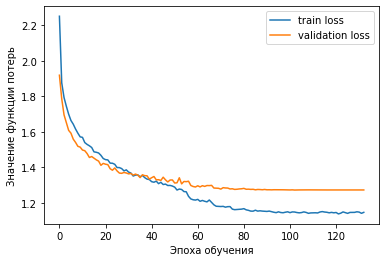

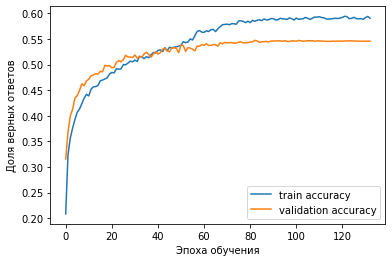

In [13]:
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение функции потерь')
plt.legend()

plt.figure()
plt.plot(history.history[acc_name], label='train accuracy')
plt.plot(history.history[val_acc_name], label='validation accuracy')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()

plt.show()

In [14]:
model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 0s 31us/sample - loss: 1.2763 - acc: 0.5475


[1.276262749481201, 0.5475]

In [15]:
preds = model.predict(test_images)

print("Test data evaluation:")
print(classification_report(test_labels.argmax(axis=1), preds.argmax(axis=1), target_names=class_names))

Test data evaluation:
              precision    recall  f1-score   support

    airplane       0.65      0.55      0.59      1000
  automobile       0.67      0.67      0.67      1000
        bird       0.46      0.38      0.41      1000
         cat       0.38      0.38      0.38      1000
        deer       0.45      0.52      0.49      1000
         dog       0.49      0.39      0.43      1000
        frog       0.52      0.67      0.59      1000
       horse       0.61      0.60      0.60      1000
        ship       0.63      0.72      0.67      1000
       truck       0.62      0.61      0.61      1000

    accuracy                           0.55     10000
   macro avg       0.55      0.55      0.54     10000
weighted avg       0.55      0.55      0.54     10000



## Advanced model #1

In [16]:
tf.keras.backend.clear_session()

DROPOUT_RATE = 0.2
DENSE_SIZE = 512
ENS_MODELS_COUNT = 4

inputs = Input(shape=(32,32,3), name="Input")
h_0 = Flatten()(inputs)

outs = []
for i in range(ENS_MODELS_COUNT):
    h_1 = Dense(DENSE_SIZE, activation='relu', name="hidden_1_%d" % i)(h_0)
    h_1_2 = Dense(DENSE_SIZE, activation='tanh', name="hidden_1_2_%d" % i)(h_0)
    h_1_3 = Dense(DENSE_SIZE, activation='sigmoid', name="hidden_1_3_%d" % i)(h_0)
    h_1_concat = Concatenate()([h_1, h_1_2, h_1_3])
    drop_1 = Dropout(DROPOUT_RATE, name="dropout_1_%d" % i)(h_1_concat)

    h_2 = Dense(DENSE_SIZE, activation='relu', name="hidden_2_%d" % i)(drop_1)
    h_2_2 = Dense(DENSE_SIZE, activation='tanh', name="hidden_2_2_%d" % i)(drop_1)
    h_2_3 = Dense(DENSE_SIZE, activation='sigmoid', name="hidden_2_3_%d" % i)(drop_1)
    h_2_concat = Concatenate()([h_2, h_2_2, h_2_3])
    drop_2 = Dropout(DROPOUT_RATE, name="dropout_2_%d" % i)(h_2_concat)

    predictions = Dense(10, activation='softmax', name="Output_%d" % i)(drop_2)
    outs.append(predictions)

out = Average()(outs)

model = Model(inputs=inputs, outputs=out)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3072)         0           Input[0][0]                      
__________________________________________________________________________________________________
hidden_1_0 (Dense)              (None, 512)          1573376     flatten[0][0]                    
__________________________________________________________________________________________________
hidden_1_2_0 (Dense)            (None, 512)          1573376     flatten[0][0]                    
______________________________________________________________________________________________

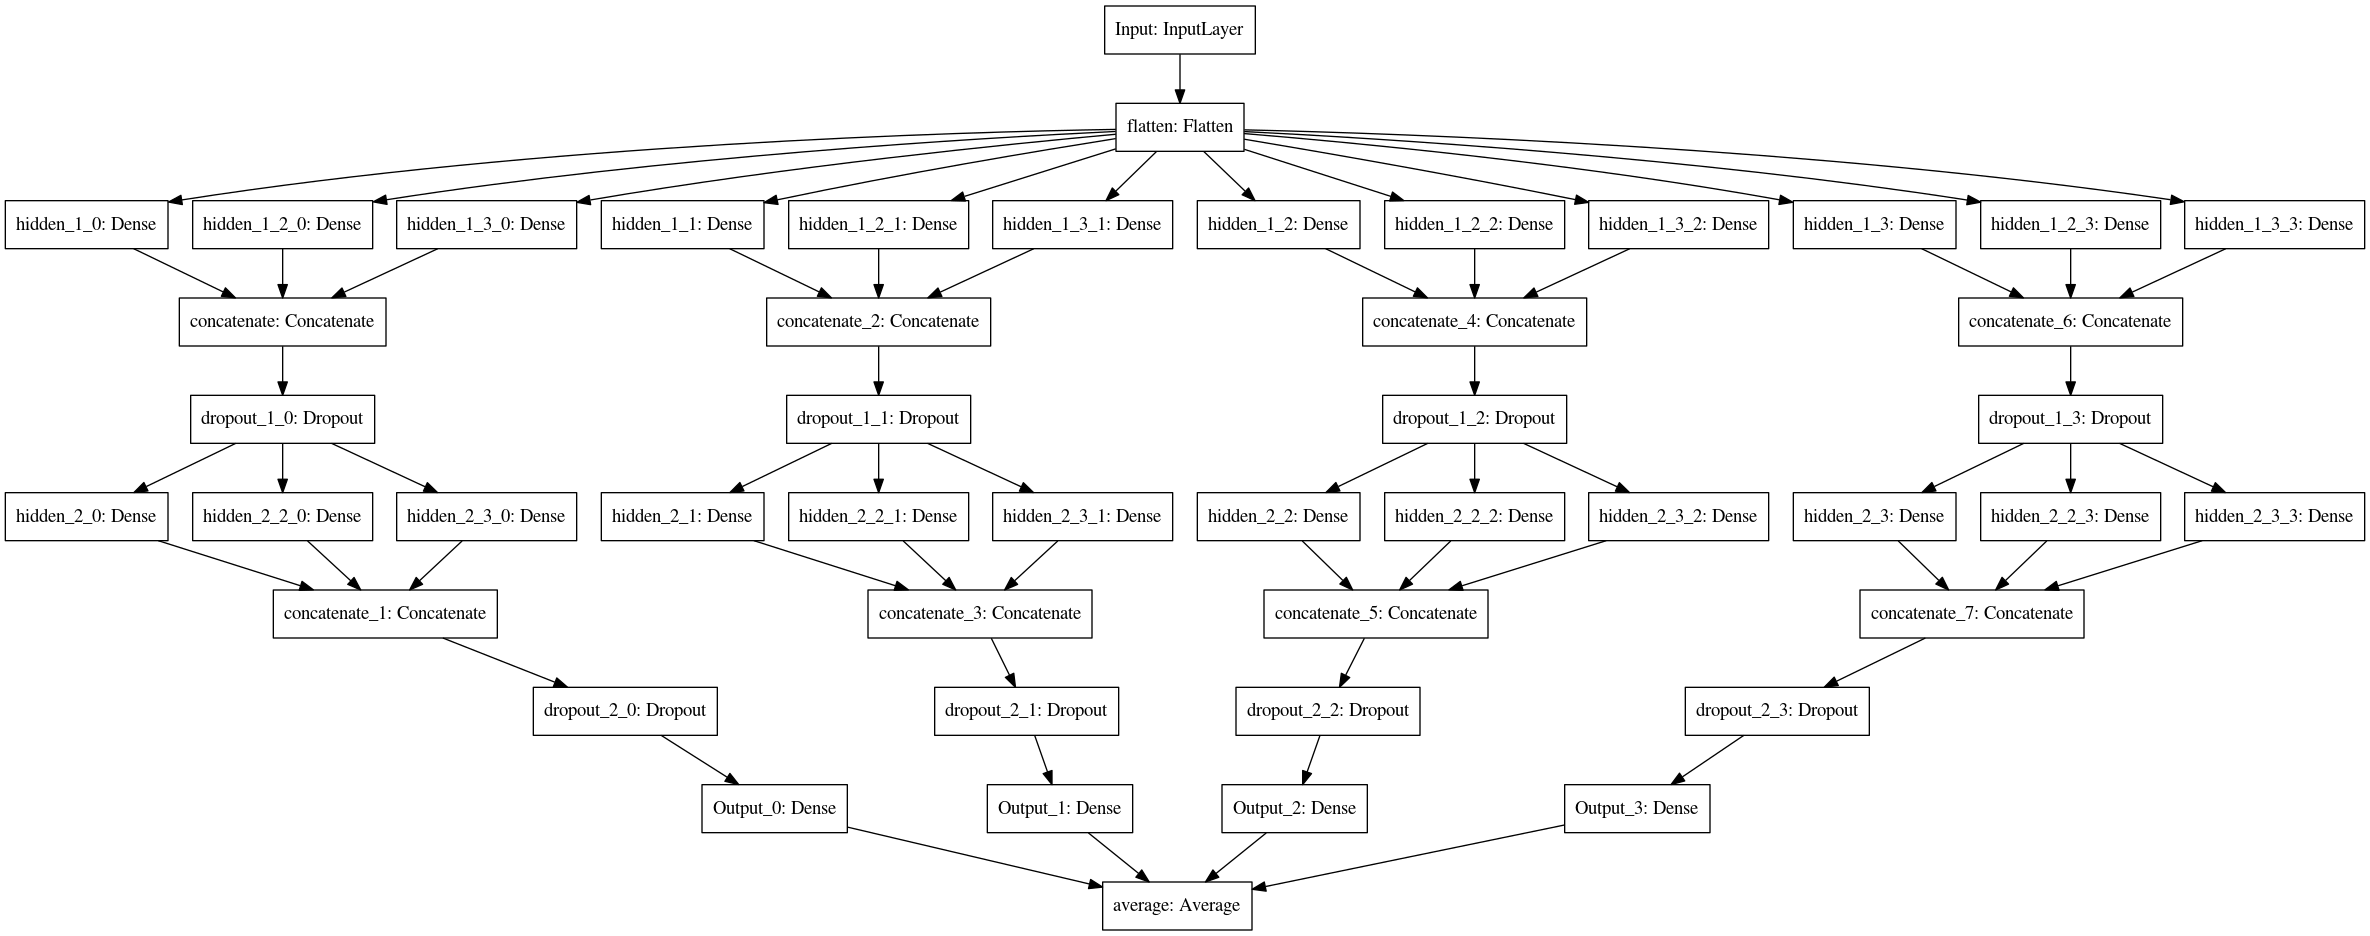

In [17]:
plot_model(model)

In [18]:
checkpoint = ModelCheckpoint('cifar10_advanced_1.hdf5',
                            monitor=val_acc_name,
                            save_best_only=True,
                            period=5,
                            verbose=1)
early_stopping_callback = EarlyStopping(monitor=val_acc_name, 
                                        min_delta=1e-9, 
                                        patience=50, 
                                        verbose=1, 
                                        mode='auto', 
                                        baseline=None, 
                                        restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor=val_acc_name,
                                           patience=5,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.00000001)

In [19]:
%%time
BATCH_SIZE = 1024
EPOCHS = 10000000000
history = model.fit(x=train_images, y=train_labels, batch_size=BATCH_SIZE,
                   epochs = EPOCHS,
                   validation_data=(test_images, test_labels),
                   
                   verbose=1,
                   callbacks=[checkpoint, learning_rate_reduction, early_stopping_callback])

Train on 50000 samples, validate on 10000 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10000000000
50000/50000 [==============================] - 3s 58us/sample - loss: 2.7197 - acc: 0.1533 - val_loss: 2.0654 - val_acc: 0.2305
Epoch 2/10000000000
50000/50000 [==============================] - 2s 48us/sample - loss: 2.0575 - acc: 0.2373 - val_loss: 1.9560 - val_acc: 0.3074
Epoch 3/10000000000
50000/50000 [==============================] - 2s 46us/sample - loss: 1.9646 - acc: 0.2870 - val_loss: 1.9013 - val_acc: 0.3044
Epoch 4/10000000000
50000/50000 [==============================] - 2s 47us/sample - loss: 1.9366 - acc: 0.3020 - val_loss: 1.9004 - val_acc: 0.2986
Epoch 5/10000000000
48128/50000 [===========================>..] - ETA: 0s - loss: 1.8940 - acc: 0.3209
Epoch 00005: val_acc improved from -inf to 0.34770, saving model to cifar10_advanced_1.hdf5
50000/50000 [==============================] - 5s 103us/sample - los

Epoch 43/10000000000
50000/50000 [==============================] - 2s 47us/sample - loss: 1.3681 - acc: 0.5135 - val_loss: 1.4613 - val_acc: 0.4919
Epoch 44/10000000000
50000/50000 [==============================] - 2s 49us/sample - loss: 1.3538 - acc: 0.5171 - val_loss: 1.4614 - val_acc: 0.4973
Epoch 45/10000000000
48128/50000 [===========================>..] - ETA: 0s - loss: 1.3443 - acc: 0.5214
Epoch 00045: val_acc improved from 0.48960 to 0.50190, saving model to cifar10_advanced_1.hdf5
50000/50000 [==============================] - 5s 92us/sample - loss: 1.3441 - acc: 0.5213 - val_loss: 1.4537 - val_acc: 0.5019
Epoch 46/10000000000
50000/50000 [==============================] - 2s 45us/sample - loss: 1.3369 - acc: 0.5238 - val_loss: 1.4515 - val_acc: 0.4978
Epoch 47/10000000000
50000/50000 [==============================] - 2s 45us/sample - loss: 1.3296 - acc: 0.5285 - val_loss: 1.4567 - val_acc: 0.4957
Epoch 48/10000000000
50000/50000 [==============================] - 2s 48us/

50000/50000 [==============================] - 2s 45us/sample - loss: 1.0332 - acc: 0.6170 - val_loss: 1.3733 - val_acc: 0.5368
Epoch 87/10000000000
50000/50000 [==============================] - 2s 48us/sample - loss: 1.0280 - acc: 0.6163 - val_loss: 1.3792 - val_acc: 0.5347
Epoch 88/10000000000
50000/50000 [==============================] - 2s 48us/sample - loss: 1.0306 - acc: 0.6200 - val_loss: 1.3728 - val_acc: 0.5411
Epoch 89/10000000000
50000/50000 [==============================] - 2s 44us/sample - loss: 1.0278 - acc: 0.6186 - val_loss: 1.3793 - val_acc: 0.5418
Epoch 90/10000000000
48128/50000 [===========================>..] - ETA: 0s - loss: 1.0225 - acc: 0.6197
Epoch 00090: val_acc did not improve from 0.54120
50000/50000 [==============================] - 2s 45us/sample - loss: 1.0223 - acc: 0.6198 - val_loss: 1.3778 - val_acc: 0.5412
Epoch 91/10000000000
50000/50000 [==============================] - 2s 46us/sample - loss: 1.0227 - acc: 0.6210 - val_loss: 1.3755 - val_acc: 

48128/50000 [===========================>..] - ETA: 0s - loss: 0.9551 - acc: 0.6419
Epoch 00128: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
50000/50000 [==============================] - 2s 45us/sample - loss: 0.9545 - acc: 0.6416 - val_loss: 1.3820 - val_acc: 0.5483
Epoch 129/10000000000
50000/50000 [==============================] - 2s 48us/sample - loss: 0.9523 - acc: 0.6404 - val_loss: 1.3822 - val_acc: 0.5484
Epoch 130/10000000000
49152/50000 [============================>.] - ETA: 0s - loss: 0.9568 - acc: 0.6403
Epoch 00130: val_acc did not improve from 0.54770
50000/50000 [==============================] - 2s 48us/sample - loss: 0.9569 - acc: 0.6403 - val_loss: 1.3821 - val_acc: 0.5477
Epoch 131/10000000000
50000/50000 [==============================] - 2s 48us/sample - loss: 0.9538 - acc: 0.6411 - val_loss: 1.3828 - val_acc: 0.5482
Epoch 132/10000000000
50000/50000 [==============================] - 2s 47us/sample - loss: 0.9539 - acc: 0.6416 - val_loss:

48128/50000 [===========================>..] - ETA: 0s - loss: 0.9519 - acc: 0.6407
Epoch 00167: ReduceLROnPlateau reducing learning rate to 3.051757957450718e-08.
50000/50000 [==============================] - 2s 46us/sample - loss: 0.9528 - acc: 0.6402 - val_loss: 1.3827 - val_acc: 0.5491
Epoch 168/10000000000
50000/50000 [==============================] - 2s 49us/sample - loss: 0.9523 - acc: 0.6421 - val_loss: 1.3827 - val_acc: 0.5491
Epoch 169/10000000000
50000/50000 [==============================] - 3s 54us/sample - loss: 0.9525 - acc: 0.6434 - val_loss: 1.3827 - val_acc: 0.5491
Epoch 170/10000000000
48128/50000 [===========================>..] - ETA: 0s - loss: 0.9535 - acc: 0.6417
Epoch 00170: val_acc did not improve from 0.54930
50000/50000 [==============================] - 2s 49us/sample - loss: 0.9535 - acc: 0.6418 - val_loss: 1.3827 - val_acc: 0.5490
Epoch 171/10000000000
50000/50000 [==============================] - 3s 57us/sample - loss: 0.9536 - acc: 0.6413 - val_loss:

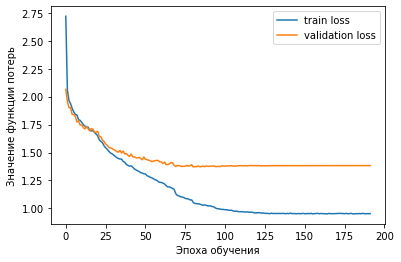

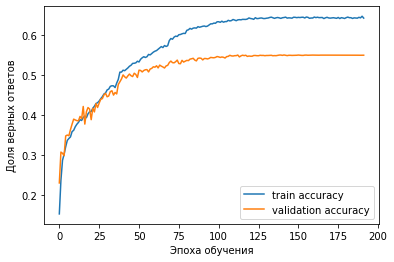

In [20]:
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение функции потерь')
plt.legend()

plt.figure()
plt.plot(history.history[acc_name], label='train accuracy')
plt.plot(history.history[val_acc_name], label='validation accuracy')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()

plt.show()

In [21]:
model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 1s 74us/sample - loss: 1.3824 - acc: 0.5495


[1.3824106554031372, 0.5495]

In [22]:
preds = model.predict(test_images)

print("Test data evaluation:")
print(classification_report(test_labels.argmax(axis=1), preds.argmax(axis=1), target_names=class_names))

Test data evaluation:
              precision    recall  f1-score   support

    airplane       0.64      0.53      0.58      1000
  automobile       0.65      0.68      0.67      1000
        bird       0.44      0.38      0.41      1000
         cat       0.38      0.41      0.39      1000
        deer       0.50      0.48      0.49      1000
         dog       0.48      0.42      0.45      1000
        frog       0.56      0.64      0.60      1000
       horse       0.61      0.63      0.62      1000
        ship       0.61      0.73      0.67      1000
       truck       0.60      0.60      0.60      1000

    accuracy                           0.55     10000
   macro avg       0.55      0.55      0.55     10000
weighted avg       0.55      0.55      0.55     10000



## Advanced model #2

In [23]:
tf.keras.backend.clear_session()

model = Sequential()
inputShape = (32, 32, 3)
chanDim = -1

model.add(Convolution2D(32, (3, 3), padding="same", input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Convolution2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Convolution2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(len(class_names)))
model.add(Activation("softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0

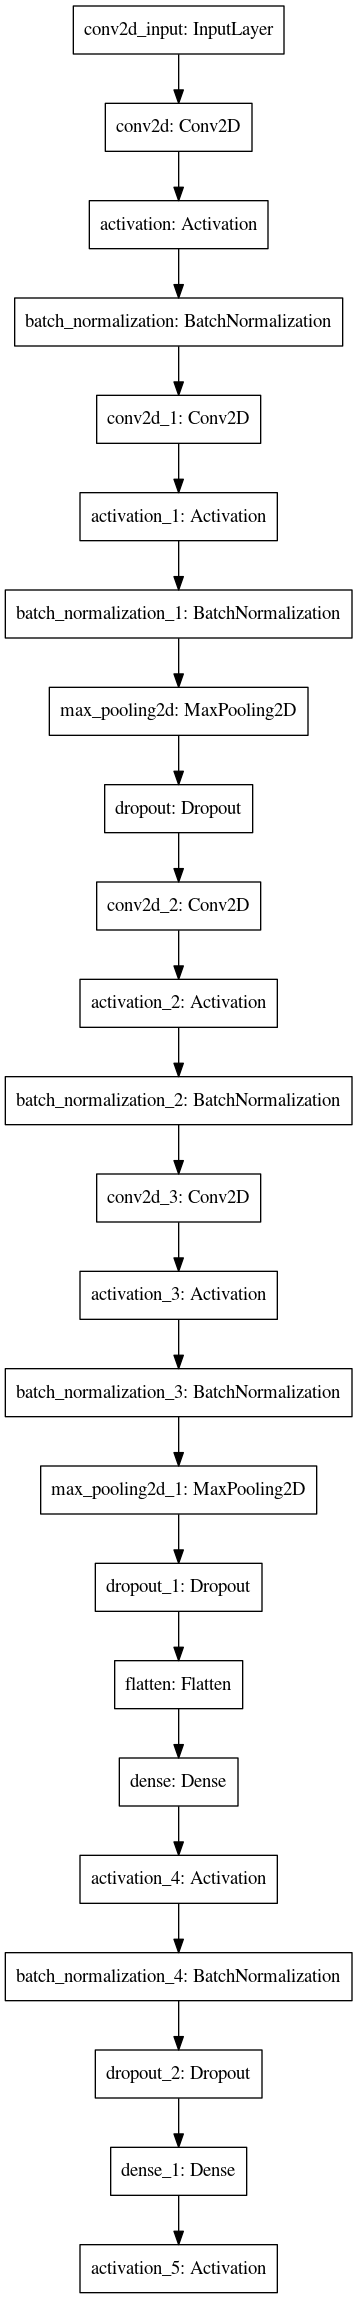

In [24]:
plot_model(model)

In [25]:
checkpoint = ModelCheckpoint('cifar10_advanced_2.hdf5',
                            monitor=val_acc_name,
                            save_best_only=True,
                            period=5,
                            verbose=1)
early_stopping_callback = EarlyStopping(monitor=val_acc_name, 
                                        min_delta=1e-9, 
                                        patience=50, 
                                        verbose=1, 
                                        mode='auto', 
                                        baseline=None, 
                                        restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor=val_acc_name,
                                           patience=5,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.00000001)

In [26]:
%%time
BATCH_SIZE = 64
EPOCHS = 10000000000
history = model.fit(x=train_images, y=train_labels, batch_size=BATCH_SIZE,
                   epochs = EPOCHS,
                   validation_data=(test_images, test_labels),
                   
                   verbose=1,
                   callbacks=[checkpoint, learning_rate_reduction, early_stopping_callback])

Train on 50000 samples, validate on 10000 samples
Epoch 1/10000000000
50000/50000 [==============================] - 12s 233us/sample - loss: 1.4512 - acc: 0.5101 - val_loss: 1.0192 - val_acc: 0.6447
Epoch 2/10000000000
50000/50000 [==============================] - 11s 215us/sample - loss: 0.9566 - acc: 0.6634 - val_loss: 0.9040 - val_acc: 0.6868
Epoch 3/10000000000
50000/50000 [==============================] - 12s 231us/sample - loss: 0.8272 - acc: 0.7116 - val_loss: 0.8786 - val_acc: 0.7080
Epoch 4/10000000000
50000/50000 [==============================] - 11s 218us/sample - loss: 0.7491 - acc: 0.7380 - val_loss: 0.7411 - val_acc: 0.7458
Epoch 5/10000000000
49728/50000 [============================>.] - ETA: 0s - loss: 0.6701 - acc: 0.7659
Epoch 00005: val_acc improved from -inf to 0.68910, saving model to cifar10_advanced_2.hdf5
50000/50000 [==============================] - 11s 226us/sample - loss: 0.6697 - acc: 0.7661 - val_loss: 0.9502 - val_acc: 0.6891
Epoch 6/10000000000
5000

50000/50000 [==============================] - 11s 224us/sample - loss: 0.0775 - acc: 0.9732 - val_loss: 0.5919 - val_acc: 0.8502
Epoch 44/10000000000
50000/50000 [==============================] - 11s 225us/sample - loss: 0.0757 - acc: 0.9737 - val_loss: 0.5988 - val_acc: 0.8513
Epoch 45/10000000000
49856/50000 [============================>.] - ETA: 0s - loss: 0.0711 - acc: 0.9761
Epoch 00045: val_acc improved from 0.84900 to 0.85080, saving model to cifar10_advanced_2.hdf5
50000/50000 [==============================] - 10s 210us/sample - loss: 0.0710 - acc: 0.9761 - val_loss: 0.5902 - val_acc: 0.8508
Epoch 46/10000000000
50000/50000 [==============================] - 11s 225us/sample - loss: 0.0706 - acc: 0.9756 - val_loss: 0.6030 - val_acc: 0.8496
Epoch 47/10000000000
50000/50000 [==============================] - 12s 235us/sample - loss: 0.0711 - acc: 0.9754 - val_loss: 0.5981 - val_acc: 0.8510
Epoch 48/10000000000
50000/50000 [==============================] - 11s 211us/sample - 

50000/50000 [==============================] - 10s 208us/sample - loss: 0.0512 - acc: 0.9824 - val_loss: 0.6173 - val_acc: 0.8544
Epoch 85/10000000000
49984/50000 [============================>.] - ETA: 0s - loss: 0.0513 - acc: 0.9825
Epoch 00085: val_acc improved from 0.85430 to 0.85490, saving model to cifar10_advanced_2.hdf5
50000/50000 [==============================] - 9s 183us/sample - loss: 0.0514 - acc: 0.9825 - val_loss: 0.6153 - val_acc: 0.8549
Epoch 86/10000000000
50000/50000 [==============================] - 9s 186us/sample - loss: 0.0507 - acc: 0.9825 - val_loss: 0.6181 - val_acc: 0.8540
Epoch 87/10000000000
50000/50000 [==============================] - 10s 195us/sample - loss: 0.0491 - acc: 0.9830 - val_loss: 0.6151 - val_acc: 0.8543
Epoch 88/10000000000
49728/50000 [============================>.] - ETA: 0s - loss: 0.0513 - acc: 0.9826
Epoch 00088: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
50000/50000 [==============================] - 9s 173u

Epoch 124/10000000000
50000/50000 [==============================] - 9s 181us/sample - loss: 0.0524 - acc: 0.9817 - val_loss: 0.6151 - val_acc: 0.8537
Epoch 125/10000000000
49856/50000 [============================>.] - ETA: 0s - loss: 0.0499 - acc: 0.9831
Epoch 00125: val_acc did not improve from 0.85500
50000/50000 [==============================] - 9s 187us/sample - loss: 0.0499 - acc: 0.9831 - val_loss: 0.6167 - val_acc: 0.8550
Epoch 126/10000000000
50000/50000 [==============================] - 9s 174us/sample - loss: 0.0510 - acc: 0.9825 - val_loss: 0.6172 - val_acc: 0.8547
Epoch 127/10000000000
50000/50000 [==============================] - 10s 192us/sample - loss: 0.0513 - acc: 0.9823 - val_loss: 0.6147 - val_acc: 0.8550
Epoch 128/10000000000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0502 - acc: 0.9831
Epoch 00128: ReduceLROnPlateau reducing learning rate to 1.525878978725359e-08.
50000/50000 [==============================] - 9s 180us/sample - loss: 0.05

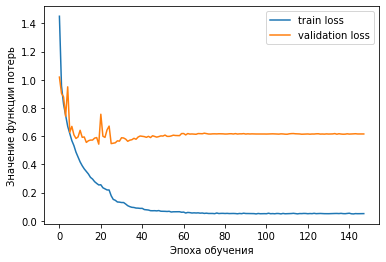

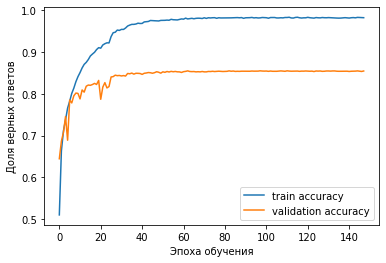

In [27]:
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение функции потерь')
plt.legend()

plt.figure()
plt.plot(history.history[acc_name], label='train accuracy')
plt.plot(history.history[val_acc_name], label='validation accuracy')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()

plt.show()

In [28]:
model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 1s 68us/sample - loss: 0.6152 - acc: 0.8554


[0.6152409723609686, 0.8554]

In [29]:
preds = model.predict(test_images)

print("Test data evaluation:")
print(classification_report(test_labels.argmax(axis=1), preds.argmax(axis=1), target_names=class_names))

Test data evaluation:
              precision    recall  f1-score   support

    airplane       0.87      0.88      0.87      1000
  automobile       0.95      0.93      0.94      1000
        bird       0.83      0.76      0.79      1000
         cat       0.74      0.70      0.72      1000
        deer       0.79      0.86      0.82      1000
         dog       0.79      0.78      0.78      1000
        frog       0.86      0.91      0.89      1000
       horse       0.90      0.89      0.89      1000
        ship       0.92      0.92      0.92      1000
       truck       0.90      0.93      0.92      1000

    accuracy                           0.86     10000
   macro avg       0.85      0.86      0.85     10000
weighted avg       0.85      0.86      0.85     10000

